## Red Wine Quality를 예측해보자

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df = pd.read_csv('./winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
# 1. 특성 살펴보기
# - 품질 분포, 히스토그램

# 2. 품질과의 상관관계
# - 컬럼 많을 때, 상관관계가 분명한 애들 위주로만 살려서 분석하자
# - 히트맵 시각화

# 3. quaility_labels 컬럼 생성
# - 0~5: 0
# - 6~7: 1
# - 8~10: 2

# 4. 훈련셋, 테스트셋 나누기
# 5. KNN 회귀로 와인 품질을 예측
# 6. 선형 회귀로 와인 품질 예측 (score 높여보자)
# 7. Ridge, Lasso로 규제해가면서 예측

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


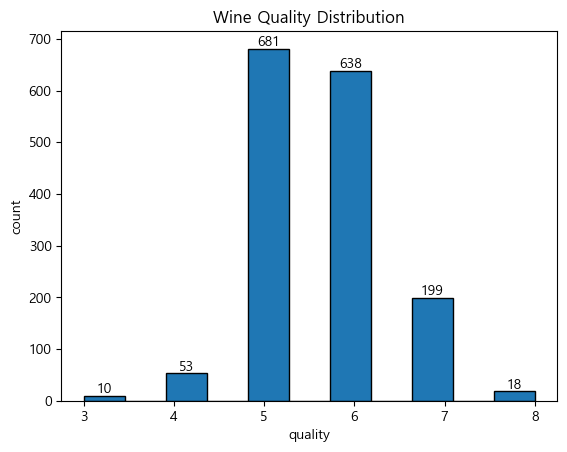

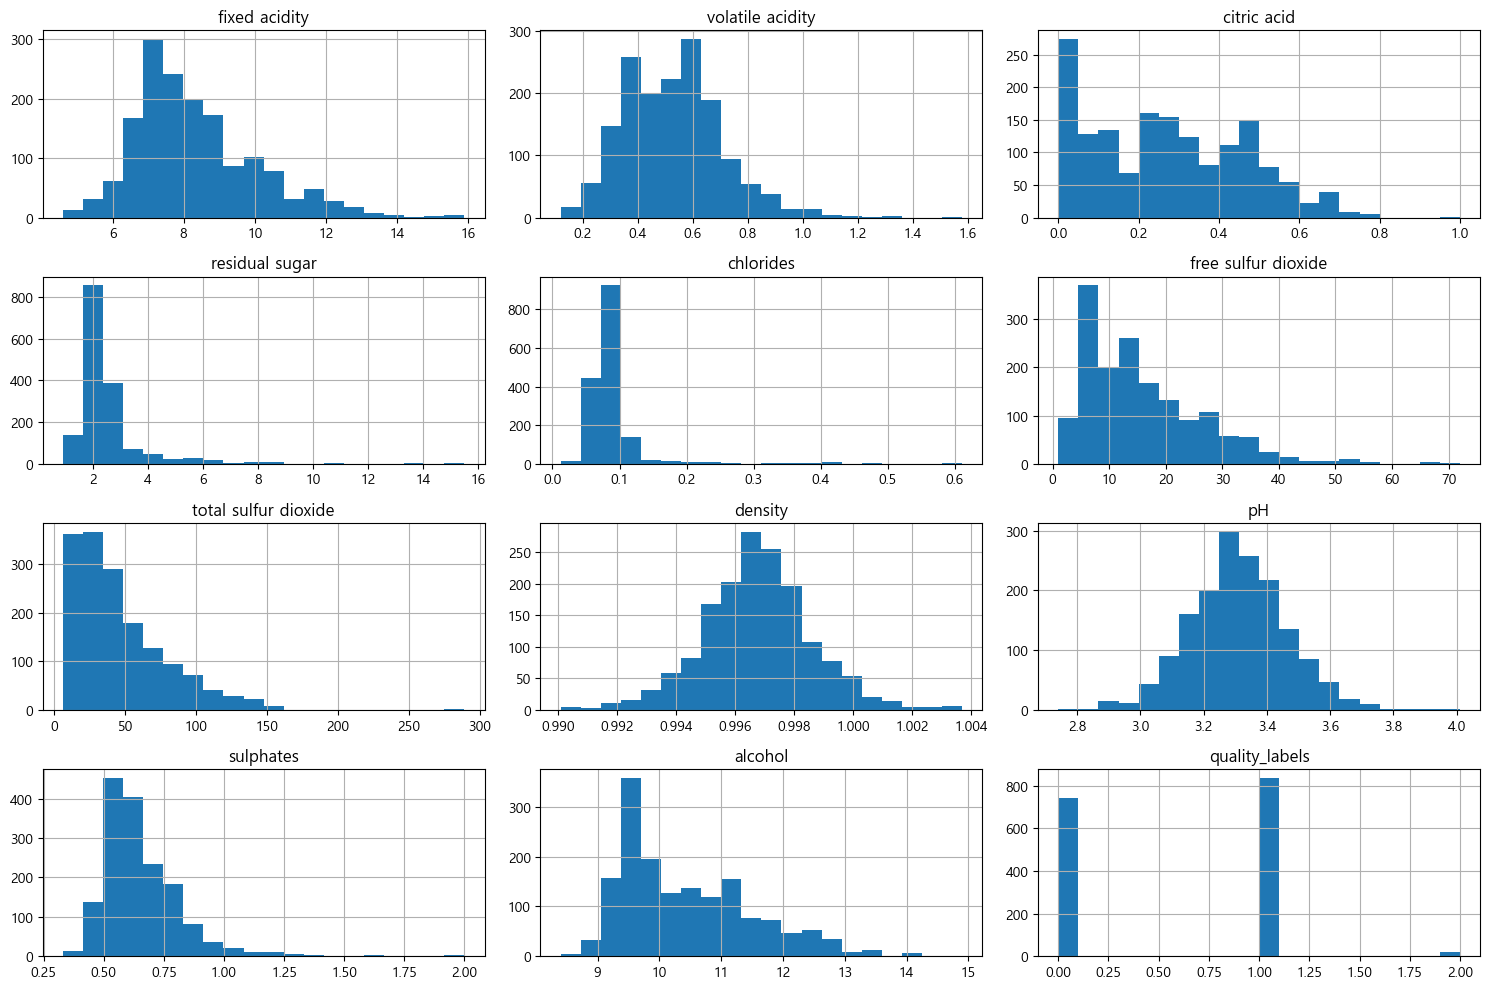

In [58]:
# 1-1. 품질별 개수 확인
print(df['quality'].value_counts())

# 1-2. 히스토그램 그리기
counts, bins, bars = plt.hist(df['quality'], bins=11, edgecolor='black')

# 각 막대 위에 개수 표시
for count, bin_edge, bar in zip(counts, bins, bars):
    if count > 0:  # 0인 경우는 표시 안함
        plt.text(bar.get_x() + bar.get_width()/2, count, str(int(count)),
                 ha='center', va='bottom')

plt.xlabel('quality')
plt.ylabel('count')
plt.title('Wine Quality Distribution')
plt.show()


# 1-3. 숫자형 컬럼만 선택 -> 분포 보고 이따가 스케일 할때 참고!
numeric_cols = df.columns.drop('quality')

# 1-4. 히스토그램 그리기
df[numeric_cols].hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64


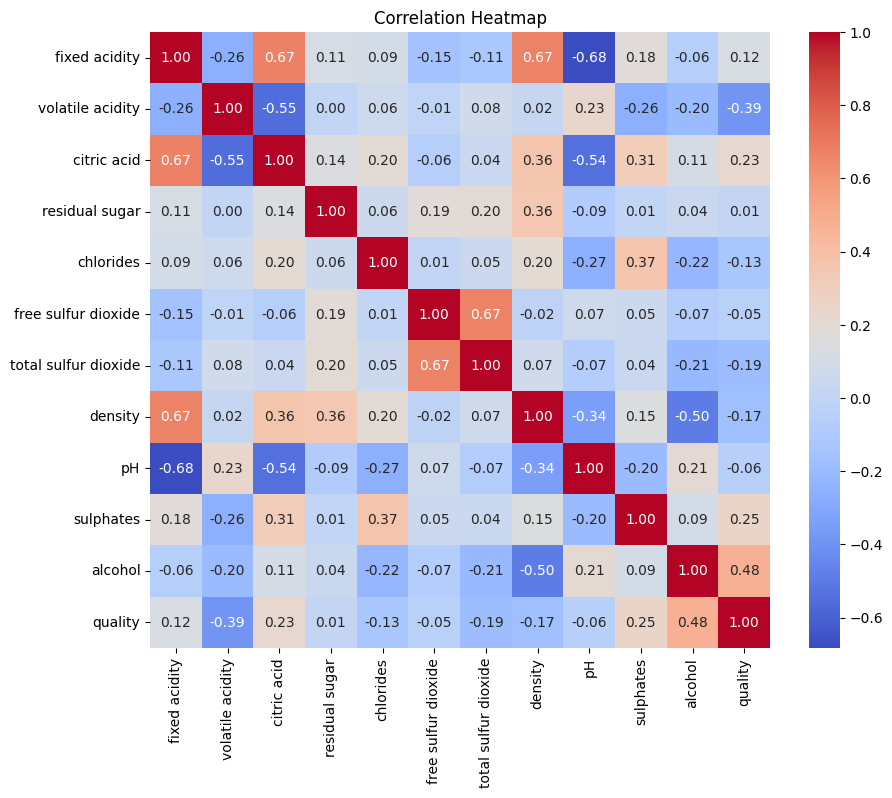

quality             1.000000
alcohol             0.476166
volatile acidity    0.390558
sulphates           0.251397
citric acid         0.226373
Name: quality, dtype: float64


In [24]:
# 숫자형 컬럼들만 상관관계 계산
corr = df.corr(numeric_only=True)
print(corr['quality'].sort_values(ascending=False))

# 히트맵으로 시각화
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# quality와 상관 높은 변수 몇 개만 보기
top_features = corr['quality'].abs().sort_values(ascending=False).head(5)
print(top_features)

In [ ]:
#피어슨 상관계수(−1 ~ 1) 해석 기준
# 0.1 ~ 0.3	약한 상관 (weak)
# 0.3 ~ 0.5	중간 정도 상관 (moderate)
# 0.5 ~ 0.7	뚜렷한 상관 (strong)
# 0.7 이상	아주 강한 상관 (very strong)

# alcohol             0.476166
# volatile acidity    0.390558
# EDA라면 얘네를 주로 분석할거고, 
# sulphates           0.251397
# citric acid         0.226373
# 모델 학습할땐 얘네도 넣을 거임
# 단일 변수의 상관계수가 낮아도, 다른 변수와 결합하면 예측력이 올라갈 수 있음

<Axes: >

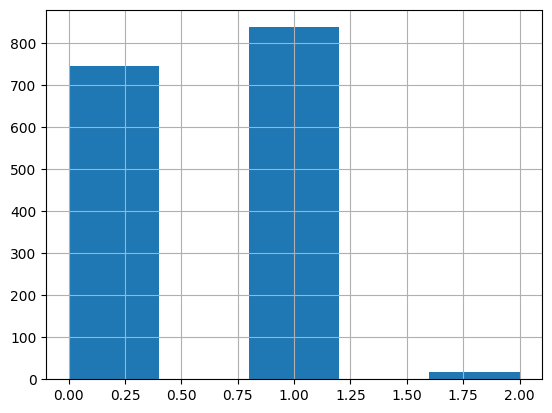

In [31]:
# quaility_labels 컬럼 생성
df['quality_labels'] = pd.cut(
    df['quality'],
    bins=[0, 5, 7, 10],       # 경계값: 0~5 / 6~7 / 8~10
    labels=[0, 1, 2],         # 각각 라벨링
    include_lowest=True # 구간 나눌 때 왼쪽(최소값) 경계값을 포함시킬지 여부
).astype(int)

df['quality_labels'].hist(bins=5)

### 여기서부터 머신러닝 활용

In [50]:
# 4. 훈련셋, 테스트셋 나누기
from sklearn.model_selection import train_test_split

X = df[['alcohol', 'volatile acidity', 'sulphates', 'citric acid']].to_numpy()
y = df['quality'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'훈련데이터: {len(X_train)}')
print(f'테스트 데이터: {len(X_test)}')


# 스케일링
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

훈련데이터: 1279
테스트 데이터: 320


In [53]:
# 5. KNN 회귀로 와인 품질을 예측
from sklearn.neighbors import KNeighborsRegressor

# 주변 5개
kn = KNeighborsRegressor(n_neighbors=5)
kn.fit(X_train, y_train)

kn.score(X_train, y_train), kn.score(X_test, y_test)


(0.5271286313759906, 0.3810307984279503)

In [54]:
# 5-1. 최적의 k값을 찾아서.....
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors': list(range(3,11))}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'n_neighbors': 10} 0.3058895575611385


In [55]:
# 6. 선형 회귀로 와인 품질 예측 (score 높여보자)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr = LogisticRegression()
lr.fit(X_train, y_train)

# 훈련, 테스트 점수
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5824863174354965
0.55625


In [ ]:
# 7. 다항회귀 (스케일링 필수)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_results = []
for degree in [2, 3, 4]:
    print(f'\n{degree}차수 다항식 특성 실험')
    # 다항식 특성 생성
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    print(f'원래 특성 수: {X_train.shape[1]}')
    print(f'다항식 특성 수: {X_train_poly.shape[1]}')

    # 모델 훈련
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)

    # 성능 평가
    poly_score = lr_poly.score(X_test_poly, y_test)
    poly_results.append((degree, poly_score))
    print(f'다항식 차수별 점수: {degree} -> {poly_score:.4f}')

    # Overfitting 체크를 위한 성능 확인
    train_score = lr_poly.score(X_train_poly, y_train)
    print(f'훈련 -> {train_score:.4f}')
    print(f'과적합정도 -> {train_score - poly_score:.4f}')


best_degree, best_score = max(poly_results, key=lambda x: x[1])
print(best_degree, best_score)




# # 시각화를 위해 다시 훈련
# poly_best = PolynomialFeatures(degree=best_degree)
# X_train_poly_best = poly_best.fit_transform(X_train)
# X_test_poly_best = poly_best.transform(X_test)

# lr_poly_best = LinearRegression()
# lr_poly_best.fit(X_train_poly_best, y_train)
# lr_poly_best_score = lr_poly_best.score(X_test_poly_best, y_test)
# lr_poly_best_pred = lr_poly_best.predict(X_test_poly_best)


2차수 다항식 특성 실험
원래 특성 수: 4
다항식 특성 수: 14
다항식 차수별 점수: 2 -> 0.3948
훈련 -> 0.3561
과적합정도 -> -0.0388

3차수 다항식 특성 실험
원래 특성 수: 4
다항식 특성 수: 34
다항식 차수별 점수: 3 -> 0.4143
훈련 -> 0.3863
과적합정도 -> -0.0280

4차수 다항식 특성 실험
원래 특성 수: 4
다항식 특성 수: 69
다항식 차수별 점수: 4 -> 0.2475
훈련 -> 0.4291
과적합정도 -> 0.1816
3 0.4142644628153054


In [ ]:
# # 예측 vs 실제값 비교
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 3, 1)
# plt.scatter(y_test, lr_basic_pred, alpha=0.6, color='blue')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('실제 품질')
# plt.ylabel('예측 품질')
# plt.title(f'기본 선형 회귀\n(R² = {lr_basic_score:.3f})')

# plt.subplot(1, 3, 2)
# plt.scatter(y_test, lr_poly_best_pred, alpha=0.6, color='green')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('실제 품질')
# plt.ylabel('예측 품질')
# plt.title(f'다항식 선형회귀 (degree={best_degree})\n(R² = {lr_poly_best_score:.3f})')

# plt.subplot(1, 3, 3)
# # 잔차 비교
# residuals_basic = y_test - lr_basic_pred
# residuals_poly = y_test - lr_poly_best_pred

# plt.scatter(lr_basic_pred, residuals_basic, alpha=0.6, color='blue', label='기본')
# plt.scatter(lr_poly_best_pred, residuals_poly, alpha=0.6, color='green', label='다항식')
# plt.axhline(y=0, color='black', linestyle='--')
# plt.xlabel('예측 품질')
# plt.ylabel('잔차 (실제-예측)')
# plt.title('잔차 비교')
# plt.legend()

# plt.tight_layout()
# plt.show()

# improvement = lr_poly_best_score - lr_basic_score
# print(f"성능 향상: {improvement:.4f} ({improvement/lr_basic_score*100:.1f}%)")

In [62]:
# 8. Ridge, Lasso로 규제해가면서 예측
from sklearn.linear_model import Ridge, Lasso

# 다항식 특성에 대해 Ridge/Lasso 적용 (앞서 만든 최적 degree 사용)
print(f"다항식 특성 (degree={best_degree}) 데이터 사용:")
print(f"특성 수: {X_train_poly_best.shape[1]}개")

# Ridge 회귀 (다항식 특성에 대해)
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_scores_poly = []
ridge_train_scores = []

print("\nRidge 회귀 (다항식 특성):")
for alpha in alphas:
    ridge_poly = Ridge(alpha=alpha)
    ridge_poly.fit(X_train_poly_best, y_train)
    
    # 테스트 성능
    ridge_score = ridge_poly.score(X_test_poly_best, y_test)
    ridge_scores_poly.append(ridge_score)
    
    # 훈련 성능 (과적합 체크용)
    ridge_train_score = ridge_poly.score(X_train_poly_best, y_train)
    ridge_train_scores.append(ridge_train_score)
    
    print(f"  alpha={alpha:7.3f}: 테스트={ridge_score:.4f}, 훈련={ridge_train_score:.4f}, 차이={ridge_train_score-ridge_score:.4f}")

best_ridge_alpha_poly = alphas[np.argmax(ridge_scores_poly)]
best_ridge_score_poly = max(ridge_scores_poly)

# Lasso 회귀 (다항식 특성에 대해)
lasso_scores_poly = []
lasso_train_scores = []

print("\nLasso 회귀 (다항식 특성):")
for alpha in alphas:
    lasso_poly = Lasso(alpha=alpha, max_iter=2000)
    lasso_poly.fit(X_train_poly_best, y_train)
    
    # 테스트 성능
    lasso_score = lasso_poly.score(X_test_poly_best, y_test)
    lasso_scores_poly.append(lasso_score)
    
    # 훈련 성능
    lasso_train_score = lasso_poly.score(X_train_poly_best, y_train)
    lasso_train_scores.append(lasso_train_score)
    
    print(f"  alpha={alpha:7.3f}: 테스트={lasso_score:.4f}, 훈련={lasso_train_score:.4f}, 차이={lasso_train_score-lasso_score:.4f}")

best_lasso_alpha_poly = alphas[np.argmax(lasso_scores_poly)]
best_lasso_score_poly = max(lasso_scores_poly)

print(f"\n🏆 최적 성능:")
print(f"Ridge (다항식) - alpha: {best_ridge_alpha_poly}, Score: {best_ridge_score_poly:.4f}")
print(f"Lasso (다항식) - alpha: {best_lasso_alpha_poly}, Score: {best_lasso_score_poly:.4f}")

다항식 특성 (degree=3) 데이터 사용:
특성 수: 35개

Ridge 회귀 (다항식 특성):
  alpha=  0.001: 테스트=0.4143, 훈련=0.3863, 차이=-0.0280
  alpha=  0.010: 테스트=0.4143, 훈련=0.3863, 차이=-0.0280
  alpha=  0.100: 테스트=0.4143, 훈련=0.3863, 차이=-0.0280
  alpha=  1.000: 테스트=0.4142, 훈련=0.3863, 차이=-0.0279
  alpha= 10.000: 테스트=0.4133, 훈련=0.3862, 차이=-0.0272
  alpha=100.000: 테스트=0.4019, 훈련=0.3811, 차이=-0.0208
  alpha=1000.000: 테스트=0.3438, 훈련=0.3327, 차이=-0.0111

Lasso 회귀 (다항식 특성):
  alpha=  0.001: 테스트=0.4145, 훈련=0.3861, 차이=-0.0284
  alpha=  0.010: 테스트=0.4097, 훈련=0.3786, 차이=-0.0311
  alpha=  0.100: 테스트=0.3259, 훈련=0.3059, 차이=-0.0201
  alpha=  1.000: 테스트=0.0155, 훈련=0.0243, 차이=0.0089
  alpha= 10.000: 테스트=-0.0056, 훈련=0.0000, 차이=0.0056
  alpha=100.000: 테스트=-0.0056, 훈련=0.0000, 차이=0.0056
  alpha=1000.000: 테스트=-0.0056, 훈련=0.0000, 차이=0.0056

🏆 최적 성능:
Ridge (다항식) - alpha: 0.001, Score: 0.4143
Lasso (다항식) - alpha: 0.001, Score: 0.4145


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

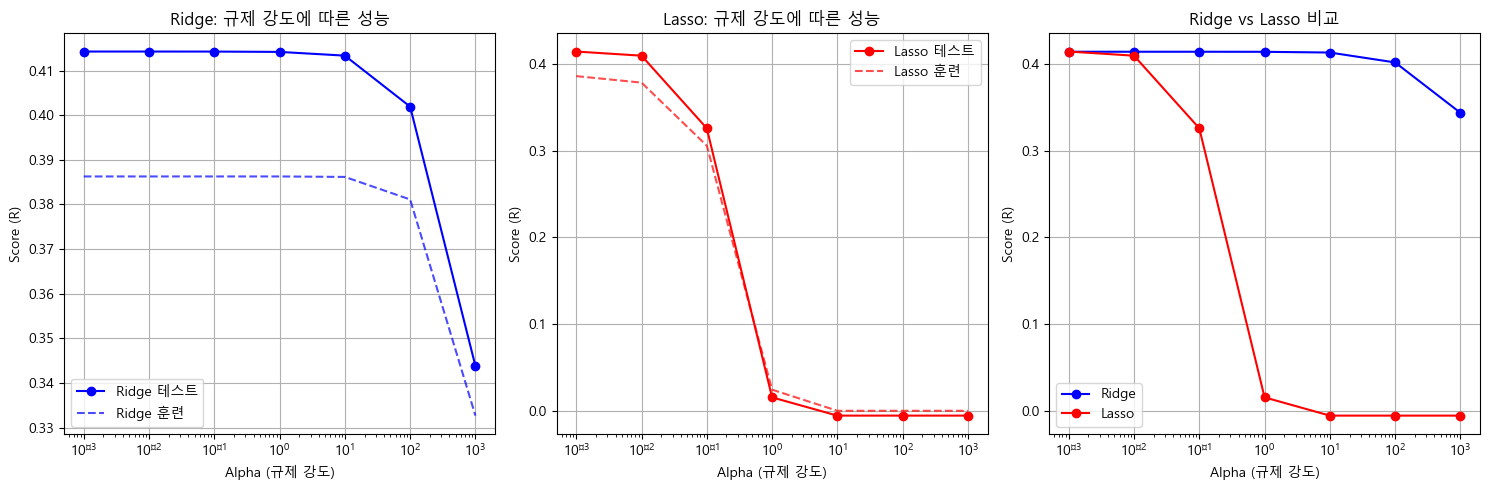

In [63]:
# Alpha 값에 따른 성능 비교 (훈련 vs 테스트)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(alphas, ridge_scores_poly, 'bo-', label='Ridge 테스트')
plt.plot(alphas, ridge_train_scores, 'b--', alpha=0.7, label='Ridge 훈련')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Ridge: 규제 강도에 따른 성능')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(alphas, lasso_scores_poly, 'ro-', label='Lasso 테스트')
plt.plot(alphas, lasso_train_scores, 'r--', alpha=0.7, label='Lasso 훈련')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Lasso: 규제 강도에 따른 성능')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(alphas, ridge_scores_poly, 'bo-', label='Ridge')
plt.plot(alphas, lasso_scores_poly, 'ro-', label='Lasso')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Ridge vs Lasso 비교')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()